# VV in SiC

An example of computing Free Induction Decay (FID) and Hahn-echo (HE) with hyperfine couplings from GIPAW for axial and basal divacancies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import ase
import pandas as pd
import warnings

sys.path.append('/home/onizhuk/midway/codes_development/pyCCE')
import pycce as pc

np.set_printoptions(suppress=True, precision=5)
warnings.simplefilter("ignore")

seed = 8805

## Axial kk-VV
First we compute FID and HE for axial divacancy.

### Build BathCell from the ground

One can set up `BathCell` instance providing the parameters of unit cell or proviing `cell` argument as 3x3 tensor, where each column define a, b, c unit cell vectors in cartesian coordinates.

In this tutorial we use the second approach.

In [2]:
# Set up unit cell with (a, b, c, alpha, beta, gamma)
sic = pc.bath.BathCell(3.073, 3.073, 10.053, 90, 90, 120, 'deg')
# z axis in cell coordinates
sic.zdir = [0, 0, 1]

Next, user has to define positions of atoms in the unit cell.
It is done with `BathCell.add_atoms` function. It takes unlimited number of arguments, each argument is a tuple. First element of the tuple is the name of the atom, second - list of xyz coordinates either in cell units (if keyword `type='cell'`, default value) or in Angstrom (if keyword `type='angstrom'`). Returns `BathCell.atoms` dictionary, which contains list of coordinates for each type of elements.

In [3]:
# position of atoms
sic.add_atoms(('Si', [0.00000000, 0.00000000, 0.1880]),
              ('Si', [0.00000000, 0.00000000, 0.6880]),
              ('Si', [0.33333333, 0.66666667, 0.4380]),
              ('Si', [0.66666667, 0.33333333, 0.9380]),
              ('C', [0.00000000, 0.00000000, 0.0000]),
              ('C', [0.00000000, 0.00000000, 0.5000]),
              ('C', [0.33333333, 0.66666667, 0.2500]),
              ('C', [0.66666667, 0.33333333, 0.7500]));

Two types of isotopes present in SiC: $^{29}$Si and $^{13}$C. We add this information with `BathCell.add_isotopes` function. The code knows most of the concentrations, so this step is actually unnecessary. If no isotopes is provided, the natural concentration of common magnetic isotopes is assumed.

In [4]:
# isotopes 
sic.add_isotopes(('29Si', 0.047), ('13C', 0.011))

# defect position in cell units
vsi_cell = [0, 0, 0.1880]
vc_cell = [0, 0, 0]

# Generate bath spin positions
atoms = sic.gen_supercell(200, remove=[('Si', vsi_cell),
                                       ('C', vc_cell)],
                          seed=seed)

### Read Quantum Espresso output

For reading hyperfine couplings there is a helper function `read_qe` in `pycce.io` module. `read_qe` takes from 1 to 3 positional arguments:

* `pwfile` name of the pw input/output file;
* `hyperfine` name of the gipaw output file containing hyperfine couplings;
* `efg` name of the gipaw output file containing electric field tensor calculations.


In the process, `read_qe` will read the cell matrix in pw file and apply it to the coordinates is necessary. However, usually we still need to rotate and translate the Quantum Espresso supercell to allign it with our `BathArray`. For that we can provide additional keywords arguments `center` and `rotation_matrix`. `center` is the position of (0, 0, 0) point in coordinates of pw file, and `rotation_matrix` is rotation matrix which aligns z-direction of the GIPAW output. This matrix, acting on the (0, 0, 1) in Cartesian coordinates of GIPAW output should produce (a, b, c) vector, alligned with zdirection of the BathCell. Keyword argument `rm_style` shows whether `rotation_matrix` contains coordinates of new basis set as rows (`'row'`, common in physics) or columns (`'col'`, common in math).

In [5]:
# Prepare rotation matrix to alling with z axis of generated atoms
# This matrix, acting on the [0, 0, 1] in Cartesian coordinates of GIPAW output
# Should produce [a, b, c] vector, alligned with zdirection of the BathCell
M = np.array([[0, 0, -1],
              [0, -1, 0],
              [-1, 0, 0]])

# Position of (0,0,0) point in cell coordinates
center = [0.6, 0.5, 0.5]
# Read GIPAW results
exatoms = pc.read_qe('axial/pw.in',
                     hyperfine='axial/gipaw.out',
                     center=center, rotation_matrix=M,
                     rm_style='col',
                     isotopes={'C':'13C', 'Si':'29Si'})

`pc.read_qe` produces instance of `BathArray`, with names of bath spins as the most common isotopes of the following elements (if keyword `isotopes` set to `None`) or from the mapping provided by the `isotopes` argument. 

### Set up CCE Simulator
In this example we set up bare `Simulator` and add properties of the spin bath later.

In [8]:
# Setting up CCE calculations
pos = sic.to_cartesian(vsi_cell)
CCE_order = 2
r_bath = 40
r_dipole = 8
B = np.array([0, 0, 500])

calc = pc.Simulator(1, pos, alpha=[0, 0, 1], beta=[0, 1, 0], magnetic_field=B)

Function `Simulator.read_bath` can be called explicitly to initiallize spin bath.
Additional keyword argument `external_bath` takes instance of `BathArray` with hyperfine couplings read from Quantum Espresso. The program then finds the spins with the same name at the same positions (within the range defined by `error_range` keyword argument) in the total bath and sets their hyperfine couplings.

Finally, we call `Simulator.generate_clusters` to find the bath spin clusters in the provided bath.

In [9]:
calc.read_bath(atoms, r_bath, external_bath=exatoms);
calc.generate_clusters(CCE_order, r_dipole=r_dipole);

### FID with DFT hyperfines

In [11]:
time_space = np.linspace(0, 0.01, 501)
N = 0

ldft = calc.cce_coherence(time_space, pulses=N, as_delay=False)

### FID with hyperfines from point dipole approximation

In [12]:
pdcalc = pc.Simulator(1, pos, alpha=[0, 0, 1], beta=[0, 1, 0], magnetic_field=B,
                      bath=atoms, r_bath=r_bath, order=CCE_order, r_dipole=r_dipole)
lpd = pdcalc.cce_coherence(time_space, pulses=N, as_delay=False)

Plot the results and and see that the predictions are significantly different.

Text(0, 0.5, 'L')

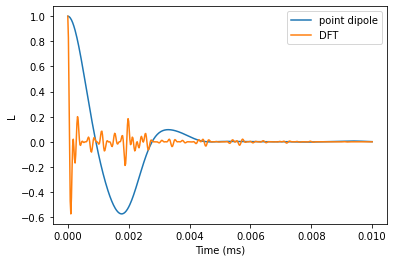

In [13]:
plt.plot(time_space, lpd.real, label='point dipole')
plt.plot(time_space, ldft.real, label='DFT')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('L')

### Hahn-echo comparison
Now we compare the predictions for Hahn-echo signal with different hyperfines.

In [14]:
he_time = np.linspace(0, 2.5, 501)
B = np.array([0, 0, 500])
N = 1

he_ldft = calc.cce_coherence(he_time, N, as_delay=False)
he_lpd = pdcalc.cce_coherence(he_time, N, as_delay=False)

Plot the results and compare. We observe that electron spin echo modulations differ significantly, while the observed decay is about the same.

Text(0, 0.5, 'L')

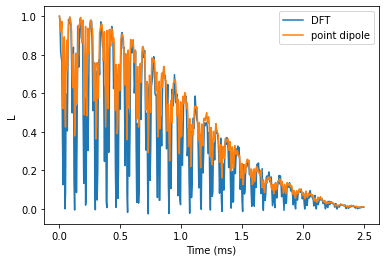

In [15]:
plt.plot(he_time, he_ldft.real, label='DFT')
plt.plot(he_time, he_lpd.real, label='point dipole')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('L')

## Basal kh-VV in SiC

Basal divacancy's Hamiltonian includes both D and E terms, which allows for mixing between +1 and -1 spin levels at zero field. 

Thus, either the generalized CCE should be used, or additional perturbational Hamiltonian terms are to be added. Here we involve the generalized CCE framework.

First, prepare rotation matrix for DFT results. The same supercell was used to compute hyperfine couplings, however z-axis of the electron spin qubit is aligned with Si-C bond, therefore we will need to rotate DFT supercell accordingly.

In [16]:
# Coordinates of vacancies in cell coordinates (note that Vsi is not located in the first unitcell)
vsi_cell = -np.array([1 / 3, 2 / 3, 0.0620])
vc_cell = np.array([0, 0, 0])

sic.zdir = [0, 0, 1]

# Rotation matrix for DFT supercell
R = pc.rotmatrix([0, 0, 1], sic.to_cartesian(vsi_cell - vc_cell))

Total spin bath can be initiallized by simply setting z direction of the `BathCell` object.

In [17]:
sic.zdir = vsi_cell - vc_cell

# Generate bath spin positions
sic.add_isotopes(('29Si', 0.047), ('13C', 0.011))
atoms = sic.gen_supercell(200, remove=[('Si', vsi_cell),
                                       ('C', vc_cell)],
                          seed=seed)

Read DFT results with `read_qe` function. To rotate in the correct frame we need to apply both changes of basis consequently

In [18]:
M = np.array([[0, 0, -1],
              [0, -1, 0],
              [-1, 0, 0]])

# Position of (0,0,0) point in cell coordinates
center = np.array([0.59401, 0.50000, 0.50000])

# Read GIPAW results
exatoms = pc.read_qe('basal/pw.in',
                     hyperfine='basal/gipaw.out',
                     center=center, rotation_matrix=(M.T @ R),
                     rm_style='col',
                     isotopes={'C':'13C', 'Si':'29Si'})

To check whether our rotations produced correct results we can find the indexes of the `BathArray` and DFT output with `pc.same_bath_indexes` function. It returns a tuple, containing the indexes of elements in the two `BathArray` instances with the same position and name. First element of the tuple - indexes of first argument, second - of the second. For that we generate supecell with `BathCell` class, containing 100% isotopes, and count the number of found indexes. It should be equal to the size of DFT supercell,

In [19]:
# isotopes 
sic.add_isotopes(('29Si', 1), ('13C', 1))
allcell = sic.gen_supercell(50, remove=[('Si', vsi_cell),
                                       ('C', vc_cell)],
                            seed=seed)

indexes, ext_indexes = pc.same_bath_indexes(allcell, exatoms, 0.2, True)
print(f"There are {indexes.size} same elements."
      " Size of the DFT supercell is {exatoms.size}")

There are 1438 same elements. Size of the DFT supercell is 1438


### Setting up calculations
Now we can safely setup calculations. We will compare results with or without bath state sampling

In [40]:
D = 1.334 * 1e6 * 2 * np.pi
E = 0.0184 * 1e6 * 2 * np.pi

calc = pc.Simulator(1, pos, bath=atoms, external_bath=exatoms,
                    r_bath=r_bath, order=CCE_order, r_dipole=r_dipole)

We can use `Simulator.eigenstates` function to generate qubit states

In [41]:
calc.eigenstates(D=D, E=E, alpha=-1, beta=0)
print(f'0 state: {calc.alpha}; 1 state: {calc.beta}')

0 state: [-0.70711+0.j  0.     +0.j -0.70711+0.j]; 1 state: [ 0.+0.j -1.+0.j  0.+0.j]


### FID Decay
Now, use generalized CCE to compute FID decay of the coherence function at different CCE orders

In [22]:
N = 0 # Number of pulses
time_space = np.linspace(0, 1, 101) # Time points at which to compute

orders = [1, 2, 3]
lgen = []

r_bath = 30
r_dipole = 8

calc = pc.Simulator(1, pos, bath=atoms, external_bath=exatoms,
                    D=D, E=E, pulses=N, alpha=-1, beta=0,
                    r_bath=r_bath, r_dipole=r_dipole)

In [23]:
for o in orders:
    calc.generate_clusters(o)
    l = calc.compute(time_space, method='gcce', mean_field=False,
                     quantity='coherence', as_delay=False)

    lgen.append(np.abs(l))

lgen = pd.DataFrame(lgen, columns=time_space, index=orders).T

We see that the results do not converge, but rather start to diverge. Bath sampling (setting `mean_field=True`) will help with that

(-0.1, 1.1)

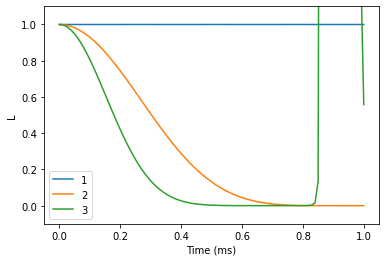

In [32]:
lgen.plot()
plt.xlabel('Time (ms)')
plt.ylabel('L')
plt.ylim(-0.1,1.1)

Note, that this approach is nbstates times more expensive than gCCE, therefore the following calculation will take a couple of minutes

In [25]:
orders = [1, 2, 3]
lgcce = []

r_bath = 30
r_dipole = 6

for o in orders:
    calc.generate_clusters(o)

    l = calc.compute(time_space, nbstates=30, seed=seed,
                     mean_field=True, method='gcce',
                     quantity='coherence', as_delay=False)

    lgcce.append(np.abs(l))

lgcce = pd.DataFrame(lgcce, columns=time_space, index=orders).T

### Compare the two results
The gCCE results are converged at 1st order. Note that we used only a small number of bath states (30), thus the calculations are not converged with respect to number of bath states. Calculations with higher number of bath states (~100) will produce correct results.

(-0.1, 1.1)

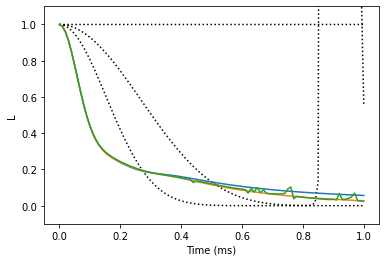

In [33]:
plt.plot(lgen, color='black', ls=':')
plt.plot(lgcce)

plt.xlabel('Time (ms)')
plt.ylabel('L')
plt.ylim(-0.1,1.1)

### Hahn-echo decay

Using similar procedure, compute the Hahn-echo decay

In [27]:
r_bath = 40
r_dipole = 8
order = 2
N = 1 # Number of pulses

calc = pc.Simulator(1, pos, bath=atoms, external_bath=exatoms,
                    pulses=N, D=D, E=E,alpha=-1, beta=0,
                    r_bath=r_bath, order=order, r_dipole=r_dipole)

In [28]:
ts = np.linspace(0, 4, 101) # time points (in ms)

In [29]:
helgen = calc.compute(ts, mean_field=False,
                      method='gcce', quantity='coherence')

Note the number of nbstates leads to significantly increased time of the calculation. The interface to mpi implementation is provided with keyword `parallel_states`. However it requires `mpi4py` installed and a run on several cores.

In [30]:
helgcce = calc.compute(time_space, nbstates=30, seed=seed,
                       mean_field=True,
                       method='gcce', quantity='coherence')

Text(0, 0.5, 'L')

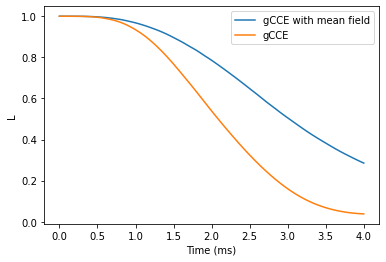

In [31]:
plt.plot(ts, helgcce, label='gCCE with mean field')
plt.plot(ts, helgen, label='gCCE')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('L')